<a href="https://colab.research.google.com/github/potulabe/symphonypy/blob/main/notebooks/Symphonypy_simple_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symphonypy usage with your own reference

In [ ]:
!pip install scanpy[leiden] openTSNE symphonypy
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"

In [2]:
import scanpy as sc
import symphonypy as sp

sc.set_figure_params(dpi=150)

adata_ref = sc.read_h5ad("PBMC_Satija.h5ad")
adata_ref.obs.head()

,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase
L1_AAACCCACATCAGTCA,P3_3,L1,P3,3,CD8 T,CD8 TEM,CD8 TEM_1,G1
L1_AAACCCATCCACACCT,P3_3,L1,P3,3,CD8 T,CD8 Naive,CD8 Naive,S
L1_AAACCCATCTGCGGAC,P1_0,L1,P1,0,CD4 T,CD4 TCM,CD4 TCM_1,S
L1_AAACCCATCTTAAGGC,P2_3,L1,P2,3,CD4 T,CD4 CTL,CD4 CTL,S
L1_AAACGAAAGATAACAC,P2_3,L1,P2,3,B,B naive,B naive kappa,S


Reference preprocessing and preparation for label transfer using Harmony. We recommend using the same normalization factor for reference and query datasets.

In [3]:
sc.pp.normalize_total(adata_ref, target_sum=1e5) # 1e5 will be used for query
sc.pp.log1p(adata_ref)
sc.pp.highly_variable_genes(
    adata_ref,
    batch_key="orig.ident",
    n_top_genes=3000,
)
adata_ref.raw = adata_ref

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


In [4]:
adata_ref = adata_ref[:, adata_ref.var.highly_variable]
sc.pp.scale(adata_ref, max_value=10)
sc.pp.pca(adata_ref, n_comps=30)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


The following step should be performed with `harmony_integrate` function from Symphonypy package (it appends additional information to AnnData object's `.uns` slot).

In [5]:
sp.pp.harmony_integrate(adata_ref, key="orig.ident")

2023-02-02 14:01:18,085 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-02-02 14:01:20,384 - harmonypy - INFO - sklearn.KMeans initialization complete.


Now let's compute UMAP for futher visualization and its coordinates transfer, and perform clustering with Leiden algorithm.

In [6]:
sc.pp.neighbors(adata_ref, use_rep="X_pca_harmony")
sc.tl.umap(adata_ref)
sc.tl.leiden(adata_ref)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


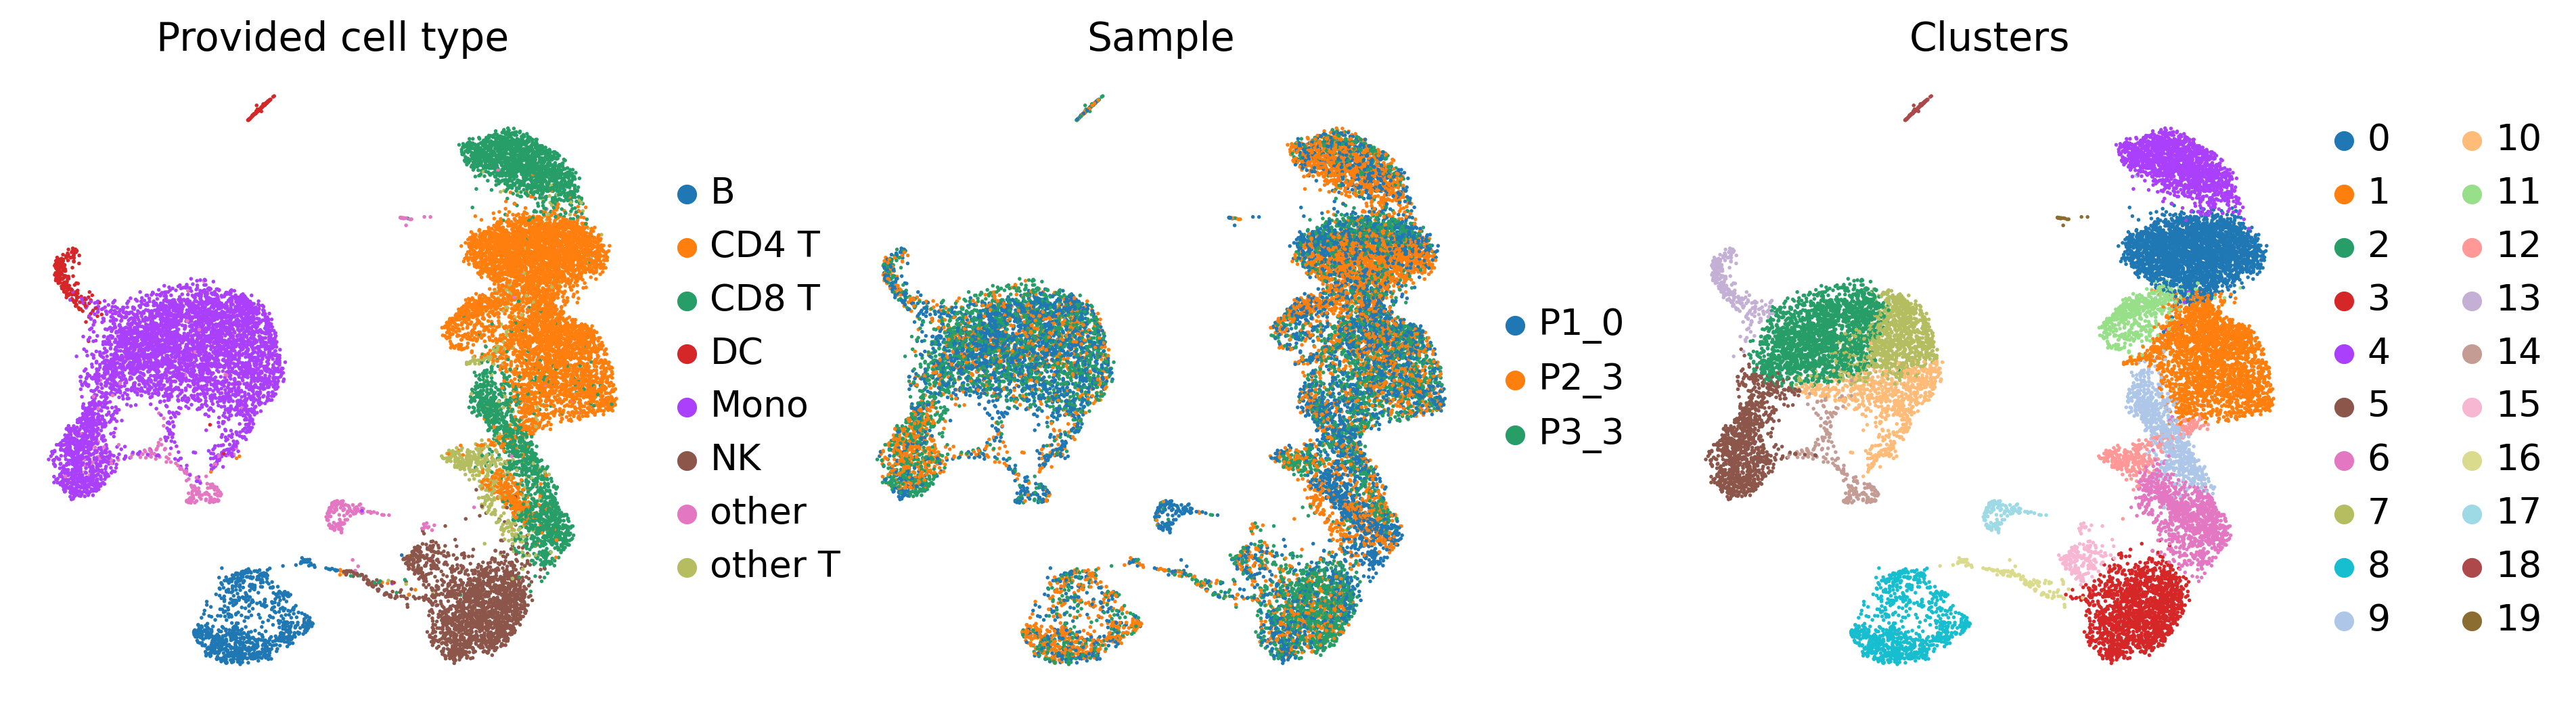

In [7]:
sc.pl.umap(
    adata_ref,
    color=["celltype.l1", "orig.ident", "leiden"],
    frameon=False,
    title=["Provided cell type", "Sample", "Clusters"],
)

## Query mapping and label transfer

In [8]:
adata_query = sc.datasets.pbmc3k()
sc.pp.normalize_total(adata_query, target_sum=1e5)
sc.pp.log1p(adata_query)

Let's do embedding mapping and label transfering with symphonypy.

In [9]:
# Mapping Harmony coordinates
sp.tl.map_embedding(adata_query=adata_query, adata_ref=adata_ref)

# Mapping UMAP coordinates
sp.tl.ingest(adata_query=adata_query, adata_ref=adata_ref)

# Labels prediction
sp.tl.transfer_labels_kNN(
    adata_query=adata_query,
    adata_ref=adata_ref,
    ref_labels=["celltype.l1", "leiden"],
)
sp.tl.per_cell_confidence(
    adata_query,
    adata_ref,
    ref_basis_adjusted = "X_pca_harmony",
    query_basis_adjusted = "X_pca_harmony"
)
sp.tl.per_cluster_confidence(
    adata_query,
    adata_ref,
    cluster_key="celltype.l1"
)

504 out of 3000 genes from the reference are missing in the query dataset or have zero std in the reference, their expressions in the query will be set to zero


/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

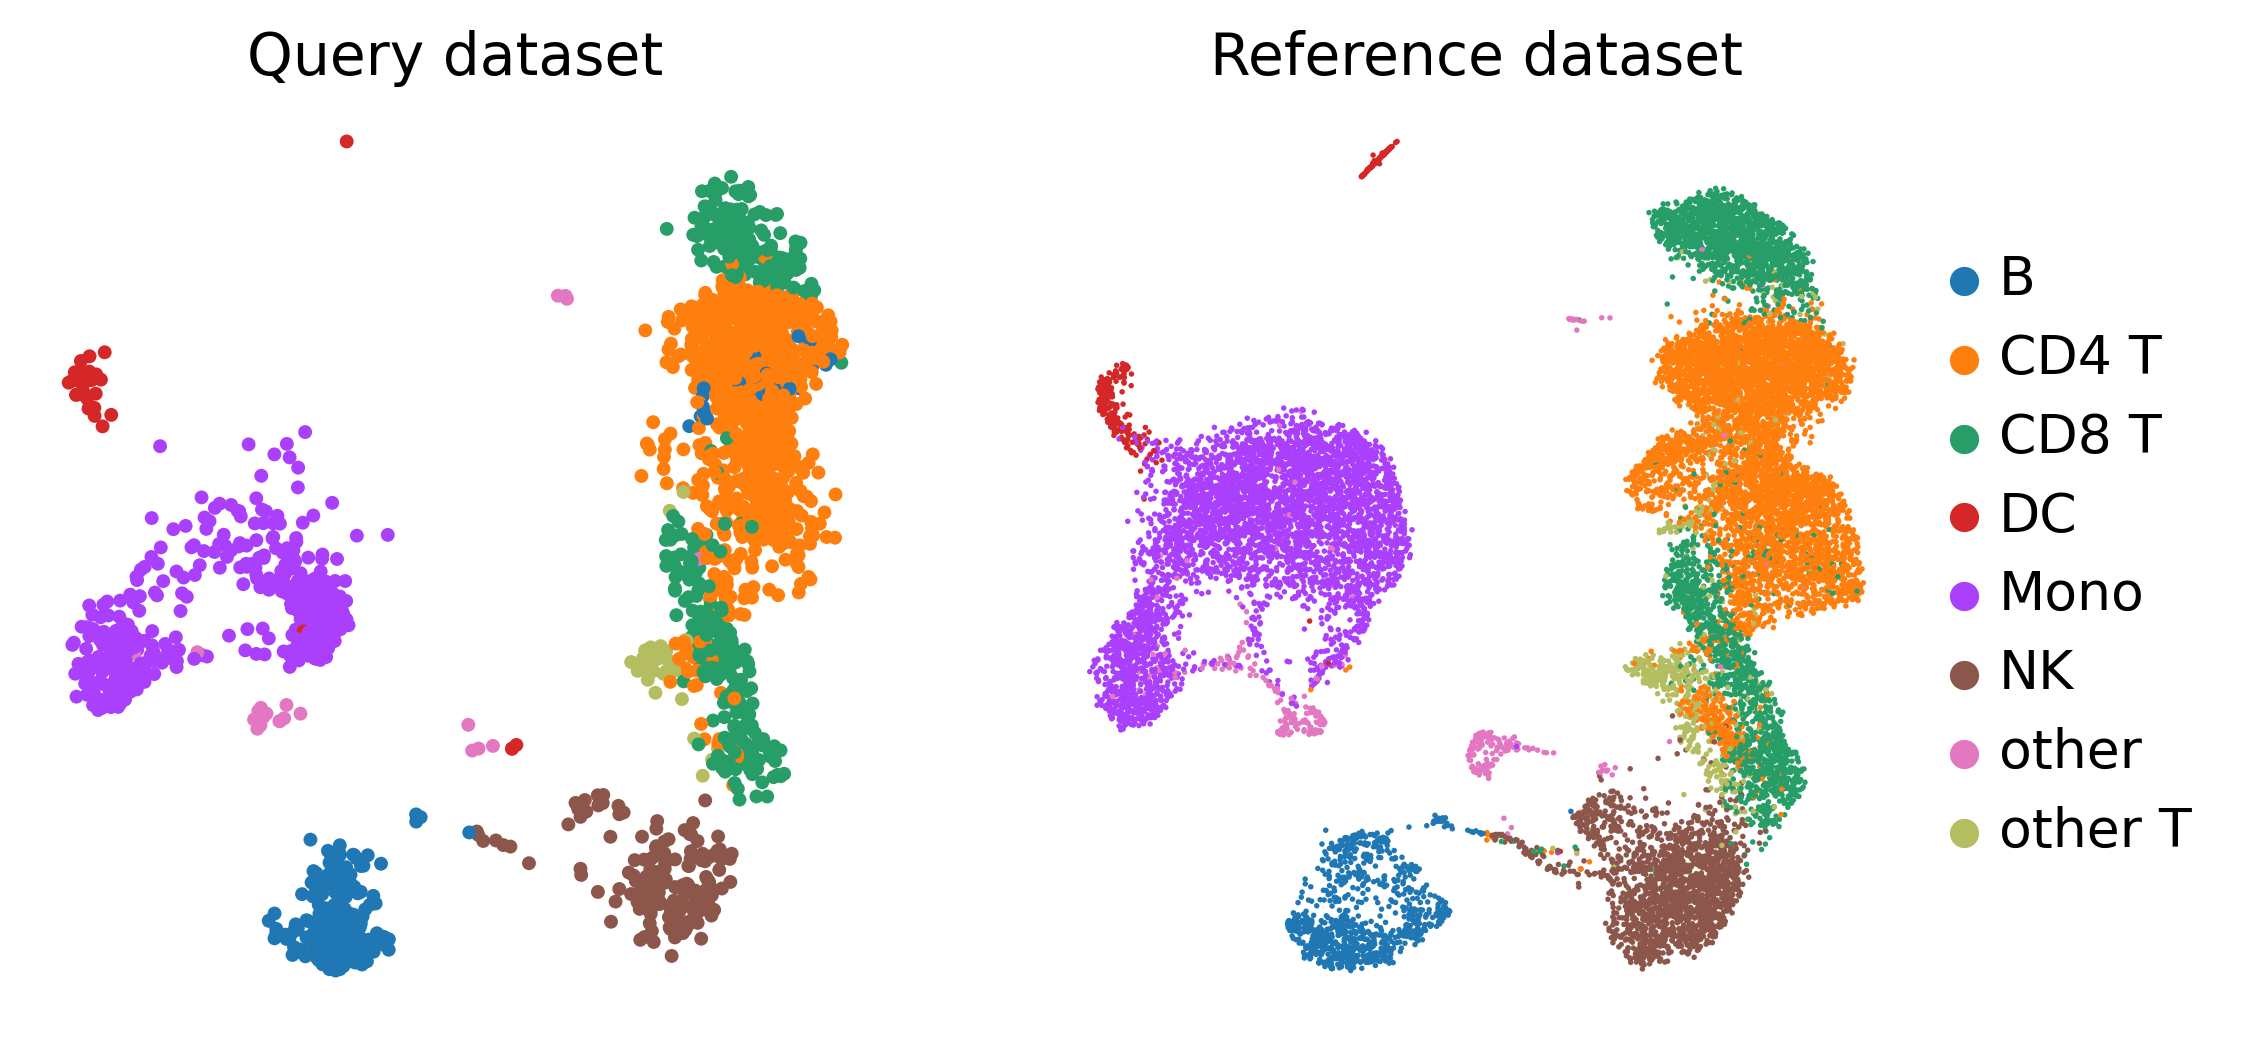

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    adata_query,
    color="celltype.l1",
    frameon=False,
    title="Query dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    adata_ref,
    color="celltype.l1",
    frameon=False,
    title="Reference dataset",
    ax=axes[1],
    show=False,
)
     

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


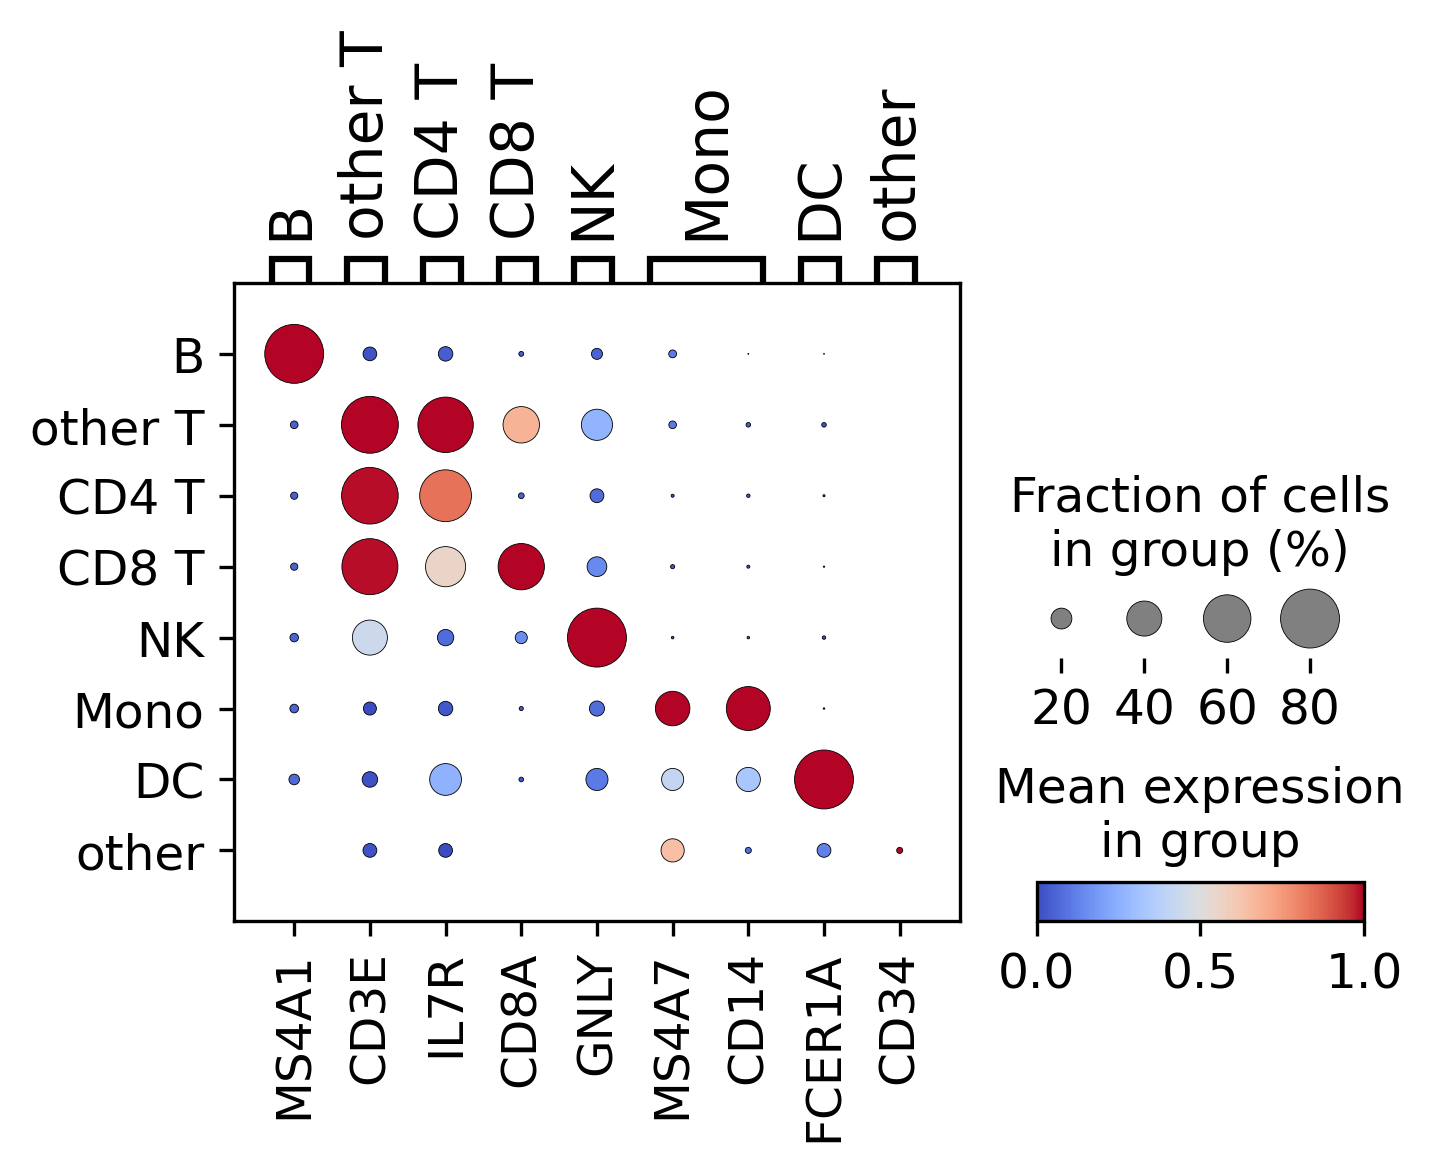

In [11]:
marker_genes = {
    "B": ["MS4A1"],
    "other T": ["CD3E"],
    "CD4 T": ["IL7R"],
    "CD8 T": ["CD8A"],
    "NK": ["GNLY"],
    "Mono": ["MS4A7", "CD14"],
    "DC": ["FCER1A"],
    "other": ["CD34"],
}

adata_query.obs["celltype.l1"] = (
    adata_query.
    obs["celltype.l1"].
    cat.
    reorder_categories(
        list(marker_genes.keys())
    )
)

sc.pl.dotplot(
    adata_query,
    var_names=marker_genes,
    groupby="celltype.l1",
    standard_scale="var",
    dot_max=0.8,
    cmap="coolwarm",
)

## t-SNE building and mapping with `openTSNE`
Here we use `openTSNE` t-SNE implementation that makes possible to add data points to existing t-SNE embedding.

In [12]:
tSNE_model = sp.tl.tsne(adata_ref, use_rep="X_pca_harmony", return_model=True)
sp.tl.tsne(adata_query, use_rep="X_pca_harmony", use_model=tSNE_model)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Reference dataset'}, xlabel='tSNE1', ylabel='tSNE2'>

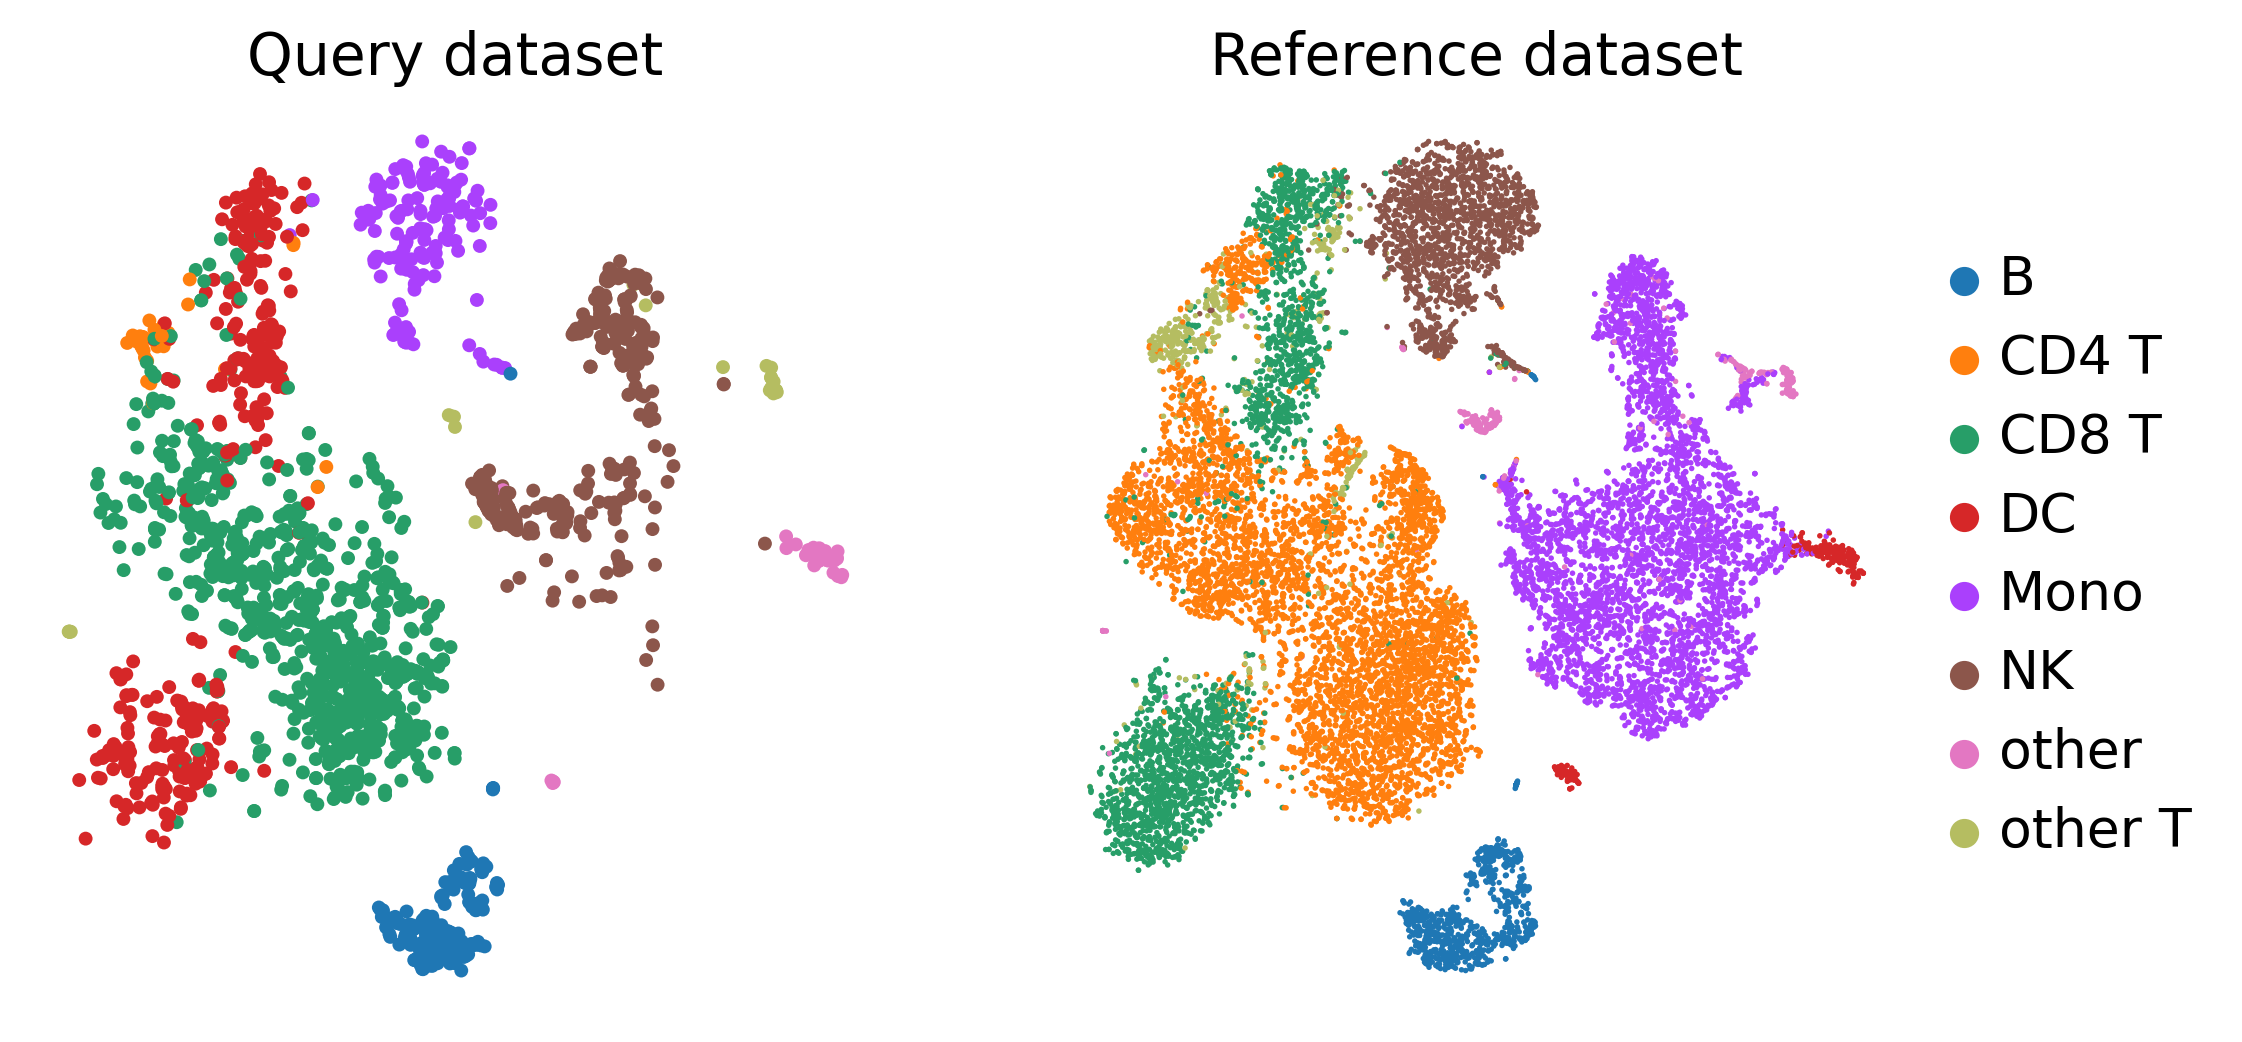

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.tsne(
    adata_query,
    color="celltype.l1",
    frameon=False,
    title="Query dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.tsne(
    adata_ref,
    color="celltype.l1",
    frameon=False,
    title="Reference dataset",
    ax=axes[1],
    show=False,
)

You can save the model with `pickle` or using the argument `save_path` of `sp.tl.tsne()`.

In [14]:
import pickle

with open("PBMC_tSNE_model.pickle", "wb") as model_file:
    pickle.dump(tSNE_model, model_file, protocol=pickle.HIGHEST_PROTOCOL)

## Mapping confidence metrics

In [15]:
adata_query

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype.l1', 'leiden', 'symphony_per_cell_dist', 'symphony_per_cluster_dist'
    var: 'gene_ids'
    uns: 'log1p', 'symphony_per_cluster_dist', 'celltype.l1_colors'
    obsm: 'X_pca_reference', 'X_pca_harmony', 'X_pca_harmony_R', 'X_umap', 'X_tsne'

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


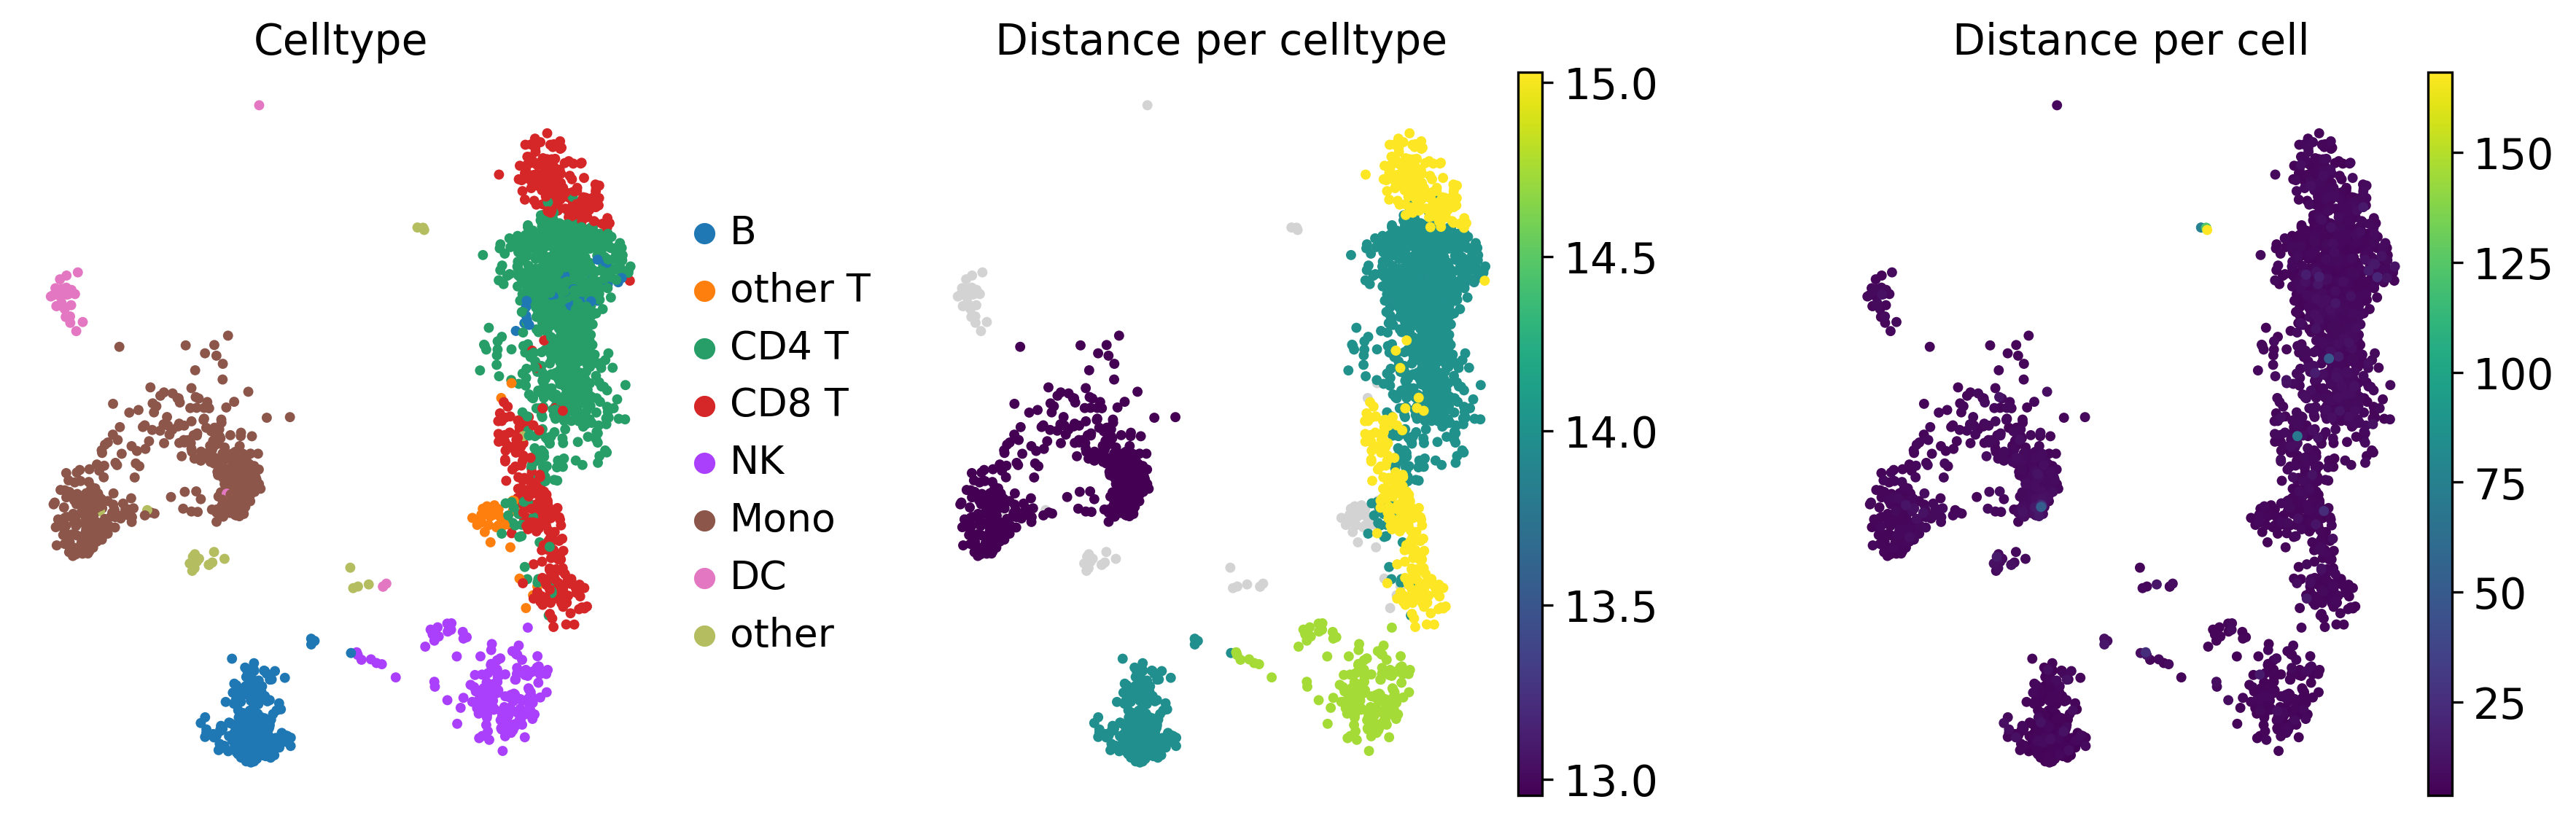

In [16]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)

sc.pl.umap(
    adata_query,
    color="celltype.l1",
    frameon=False,
    title="Celltype",
    ax=axes[0],
    show=False,
)

sc.pl.umap(
    adata_query,
    color="symphony_per_cluster_dist",
    frameon=False,
    title="Distance per celltype",
    ax=axes[1],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    adata_query,
    color="symphony_per_cell_dist",
    frameon=False,
    title="Distance per cell",
    ax=axes[2],
    show=False,
)

fig.tight_layout()

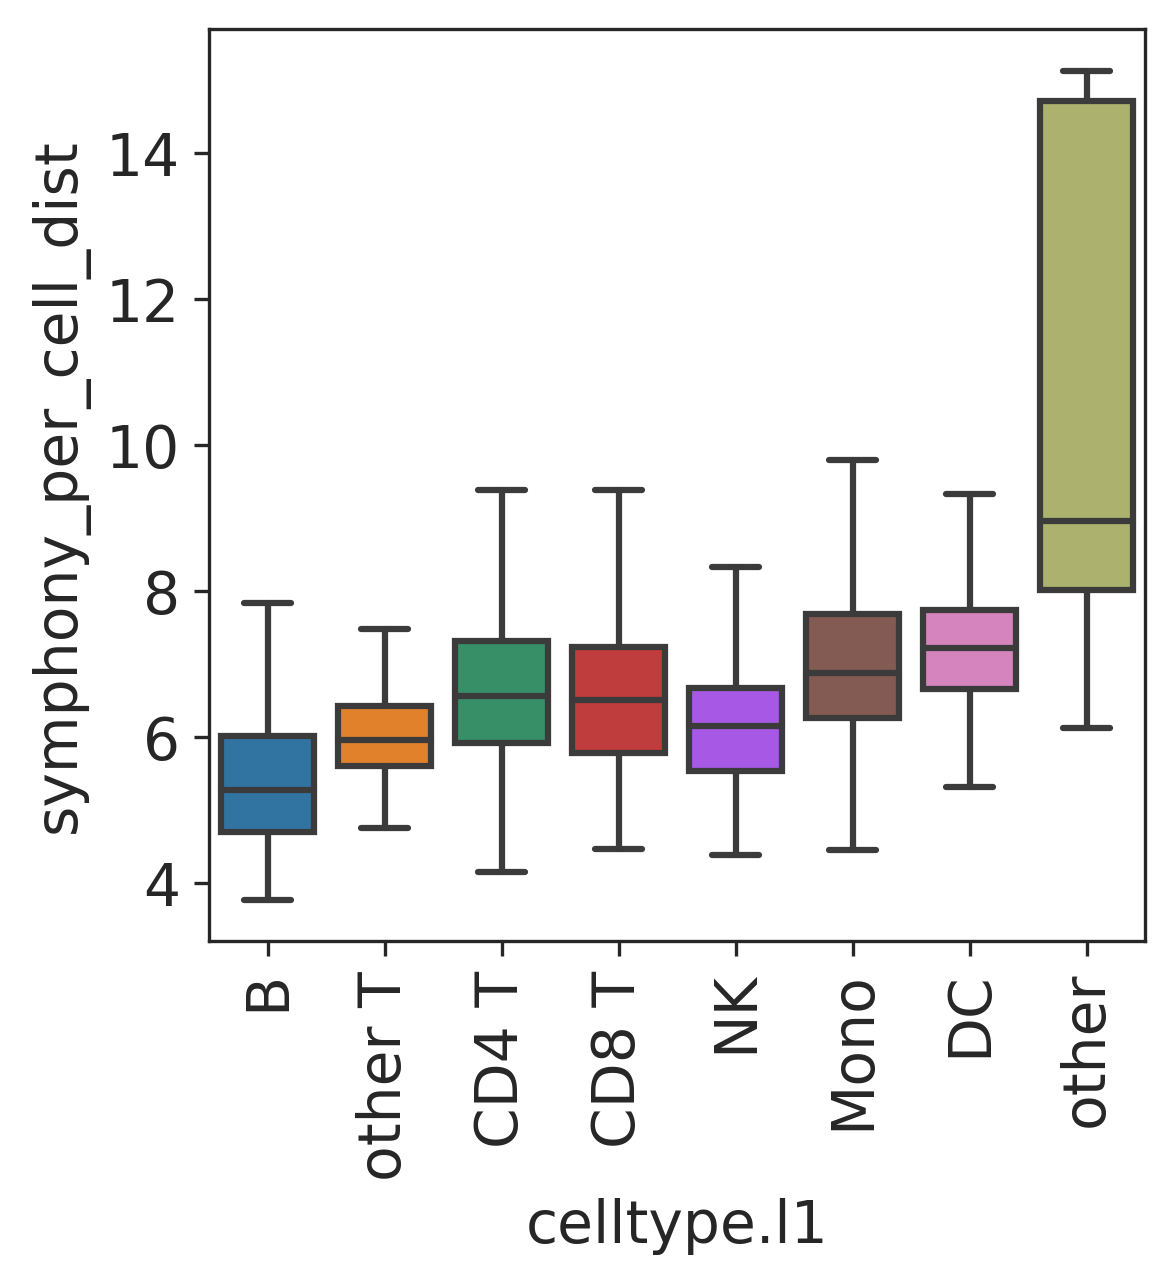

In [17]:
import seaborn as sns
sns.set_style("ticks")

sns.boxplot(data=adata_query.obs, y="symphony_per_cell_dist", x="celltype.l1", orient="v", showfliers=False)
_ = plt.xticks(rotation = 'vertical')